In [16]:
import importlib
import numpy as np
import pipeline
from importlib import reload
reload(pipeline)

<module 'pipeline' from 'C:\\Users\\einkina\\Documents\\School\\Manifold Learning\\manifold-learning\\pipeline.py'>

In [17]:
reload(pipeline)
control_vars = pipeline.get_control_vars(pipeline.get_p())
response_matrix = pipeline.generate_array_of_swiss_rolls(control_vars)
standardized_x, centered_y, ld_embedding, regression_matrix = \
    pipeline.maximum_covariance_unfolding_regression(control_vars, response_matrix)
reconstructed_y = np.dot(standardized_x, regression_matrix)

print(pipeline.compute_rre(ld_embedding, reconstructed_y))

0.01613535278710529


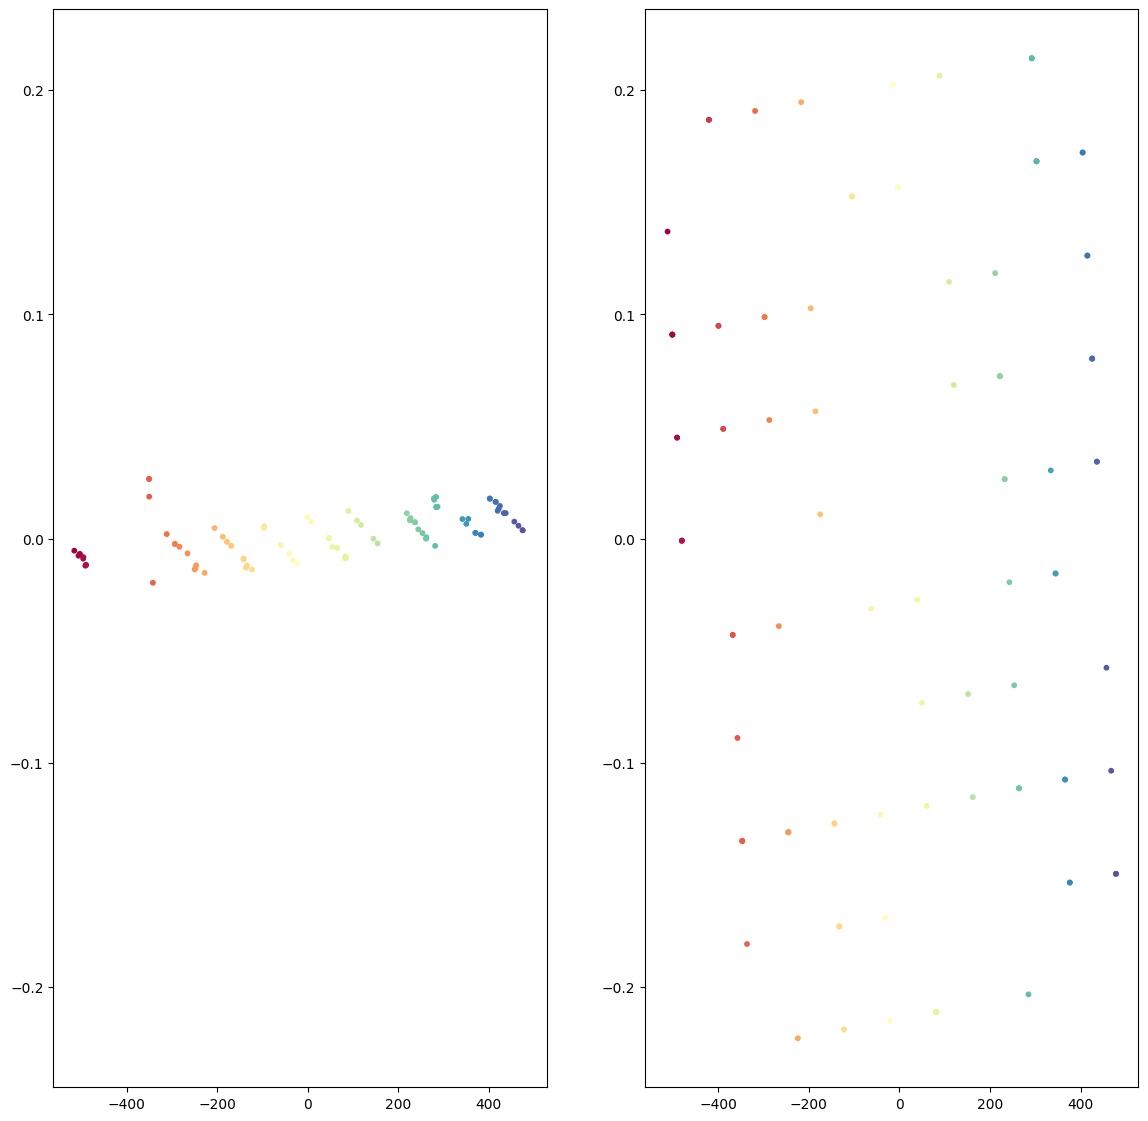

In [18]:
reload(pipeline)
pipeline.plot_two_embeddings(ld_embedding, reconstructed_y)

In [28]:
reload(pipeline)
test_control_vars = pipeline.get_control_vars(pipeline.get_p())
test_rolls = pipeline.generate_array_of_swiss_rolls(control_vars, 10)
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = pipeline.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix)
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_opt  = [ 0. 10.], x_err = 127841685.19870149
x_real = [6, 1]
x_opt  = [ 0. 10.], x_err = 192174607.053772
x_real = [9, 1]
x_opt  = [ 0. 10.], x_err = 127841685.19870149
x_real = [9, 8]
x_opt  = [ 0. 10.], x_err = 135518353.09381083
x_real = [1, 7]
x_opt  = [ 0. 10.], x_err = 117714991.53989276
x_real = [1, 8]
x_opt  = [ 0. 10.], x_err = 173752308.78646454
x_real = [4, 6]
x_opt  = [ 0. 10.], x_err = 104128945.22510055
x_real = [1, 7]
x_opt  = [ 0. 10.], x_err = 116631989.95714888
x_real = [6, 7]
x_opt  = [ 0. 10.], x_err = 204891601.80063963
x_real = [10, 5]
x_opt  = [ 0. 10.], x_err = 145555102.20001185
x_real = [4, 6]
